# Template for analyzing the CLM5-PPE
- Updated Jan 27, 2023
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
import seaborn as sns

## spin up some extra cores on CASPER

In [90]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300641', # Input your project ID here
    walltime='00:15:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [4]:
from utils import *

### map the effect of medlynslope on GPP

In [ ]:
ds=get_exp('CTL2010',tape='h0',dvs=['GPP','TLAI'])

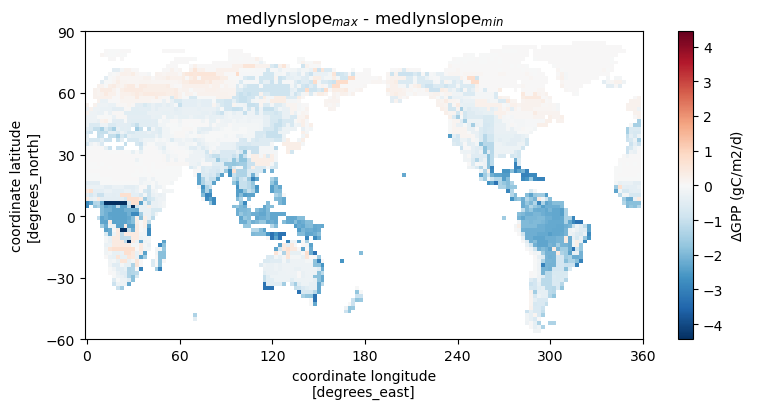

In [9]:
cf=24*60*60
p='medlynslope'
dgpp=cf*(amean(ds.GPP.sel(param=p,minmax='max')).mean(dim='year')-
         amean(ds.GPP.sel(param=p,minmax='min')).mean(dim='year'))

plt.figure(figsize=[9,4])
get_map(dgpp).plot(cbar_kwargs={'label':'$\Delta$GPP (gC/m2/d)'})
plt.ylim([-60,90])
plt.yticks(range(-60,91,30))
plt.xticks(range(0,361,60))
plt.title(p+'$_{max}$ - '+p+'$_{min}$');

### diagnose the parameters influencing LAI in Siberia
 - specifically looking at August LAI
 - this area has been dying in recent coupled simulations

In [91]:
ds=get_exp('AF1855',tape='h0',dvs=['GPP','TLAI'])

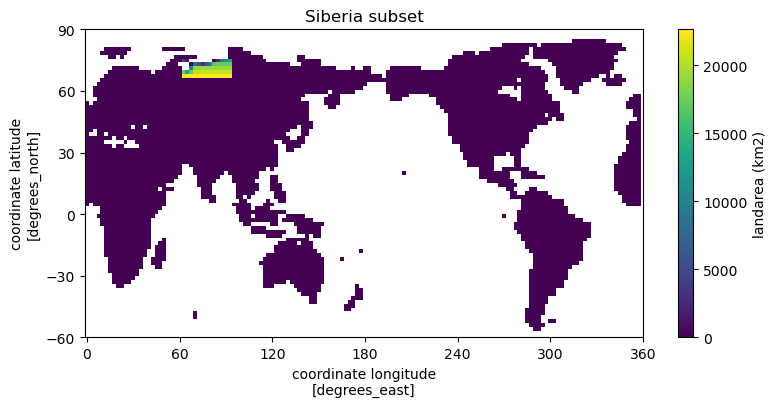

In [92]:
#create the landarea array with appropriate masking
f='clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
tmp=xr.open_dataset(f)
la=tmp.area*tmp.landfrac_orig
a1,a2=66,75
o1,o2=62,94
ix=(la.lat>=a1)&(la.lat<=a2)&(la.lon>=o1)&(la.lon<=o2)
lasib=ix*la

plt.figure(figsize=[9,4])
lasib.plot(cbar_kwargs={'label':'landarea (km2)'});
plt.ylim([-60,90])
plt.yticks(range(-60,91,30))
plt.xticks(range(0,361,60))
plt.title('Siberia subset');


In [93]:
ixt=ds['time.month']==8
lai_aug=get_map(ds.TLAI.isel(time=ixt).mean(dim='time'))
lai_aug_ann=gmean(lai_aug,lasib)

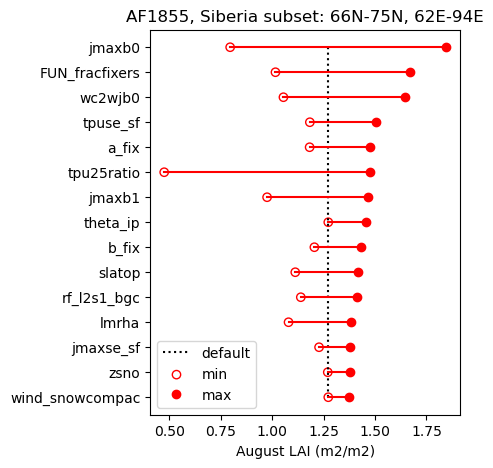

In [113]:
fig=plt.figure(figsize=[4,5])
ax=fig.add_subplot(111)
rank_plot(lai_aug_ann,15,sortby='max',ax=ax)
plt.xlabel('August LAI (m2/m2)')
plt.title('AF1855, Siberia subset: '+str(a1)+'N-'+str(a2)+'N, '+str(o1)+'E-'+str(o2)+'E')
plt.legend(['default','min','max'],loc=3);
plt.savefig('lai_siberia_af1855.png',dpi=300,bbox_inches='tight')